### Описание задачи

Имеются три датасета с данными о различных товарах, представленными в виде набора векторов, содержащих информацию о параметрах товара.

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

Необходимо:
- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.

In [1]:
import pandas as pd
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import k_means

from sklearn.preprocessing import StandardScaler

In [2]:
base = pd.read_csv('./base.csv', index_col=0)
train = pd.read_csv('./train.csv', index_col=0)
x_test = pd.read_csv('./validation.csv', index_col=0)
y_test = pd.read_csv('./validation_answer.csv', index_col=0)

### Предварительный анализ данных

#### train

In [3]:
train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.76360,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.80333,-83.81059,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.58963,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.12843,-50.83762,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.93147,-1074.464888,-22.547178,1447819-base


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [5]:
max(train.isna().sum())

0

Пропусков нет

In [6]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


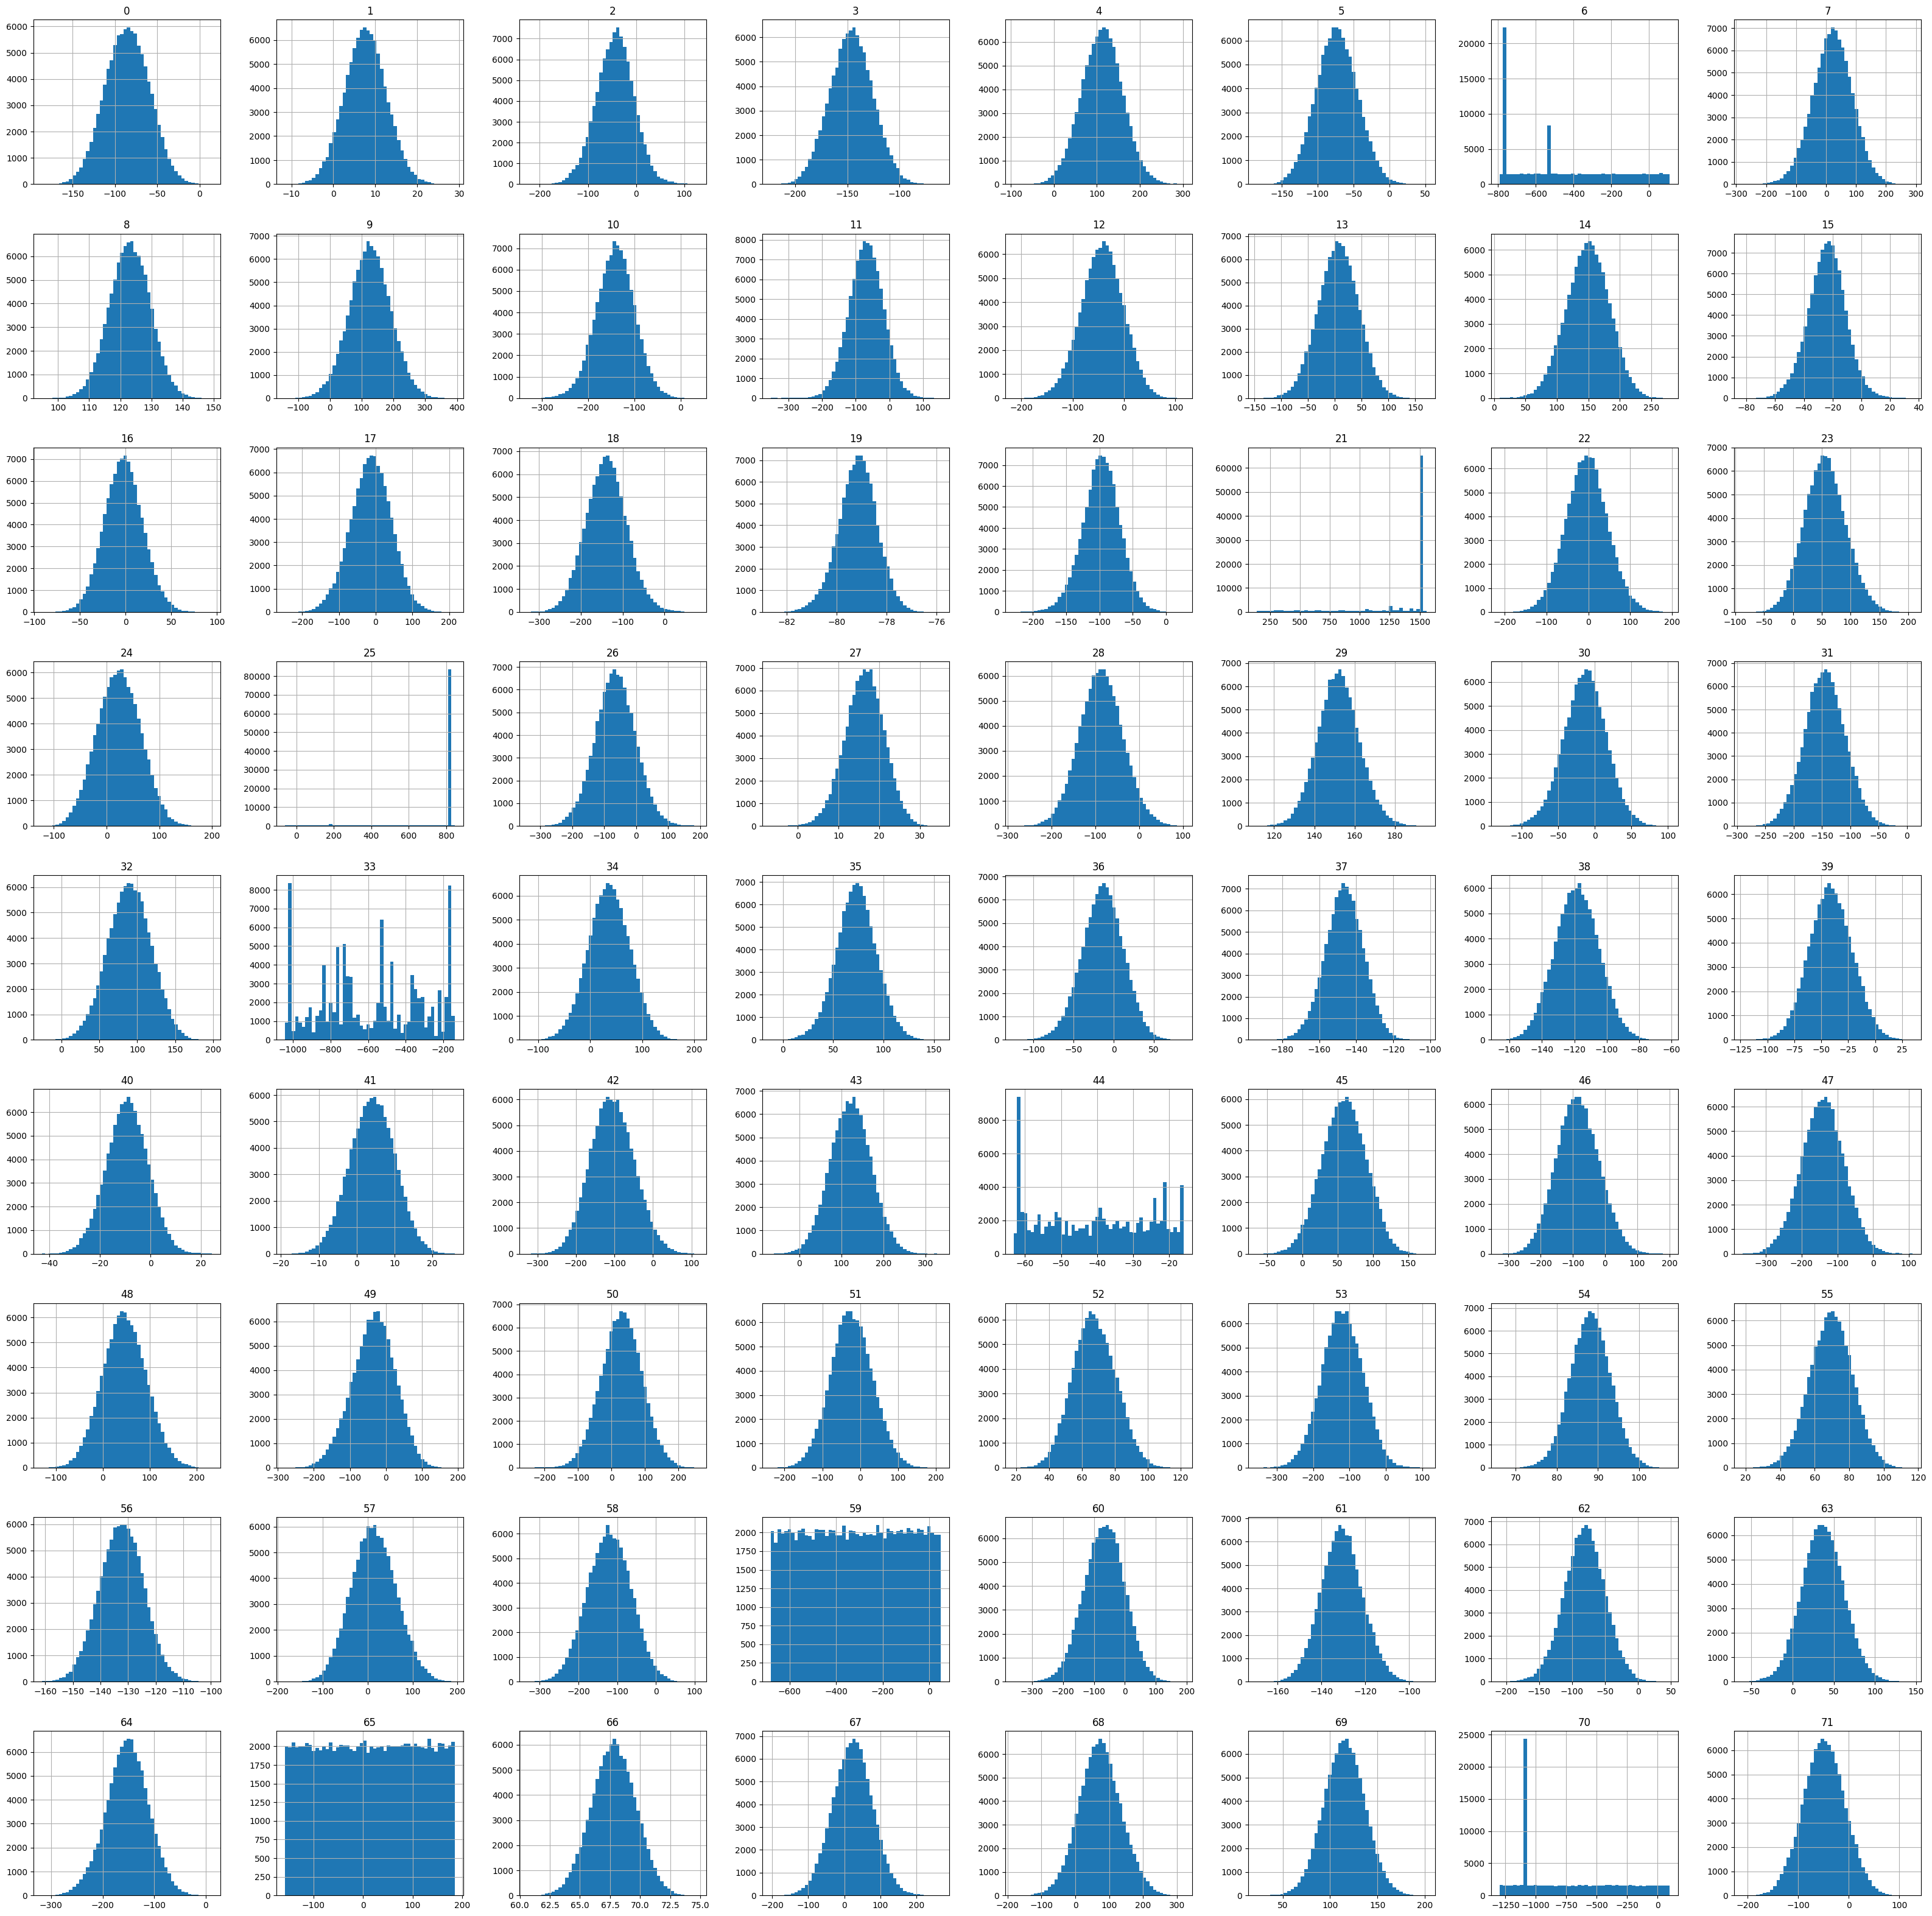

In [7]:
train.hist(bins=50, figsize=(40,40));

Значения большей части признаков распределены нормально. Проверим, есть ли выбросы и рассмотрим подробнее признаки, распределенные не нормально.

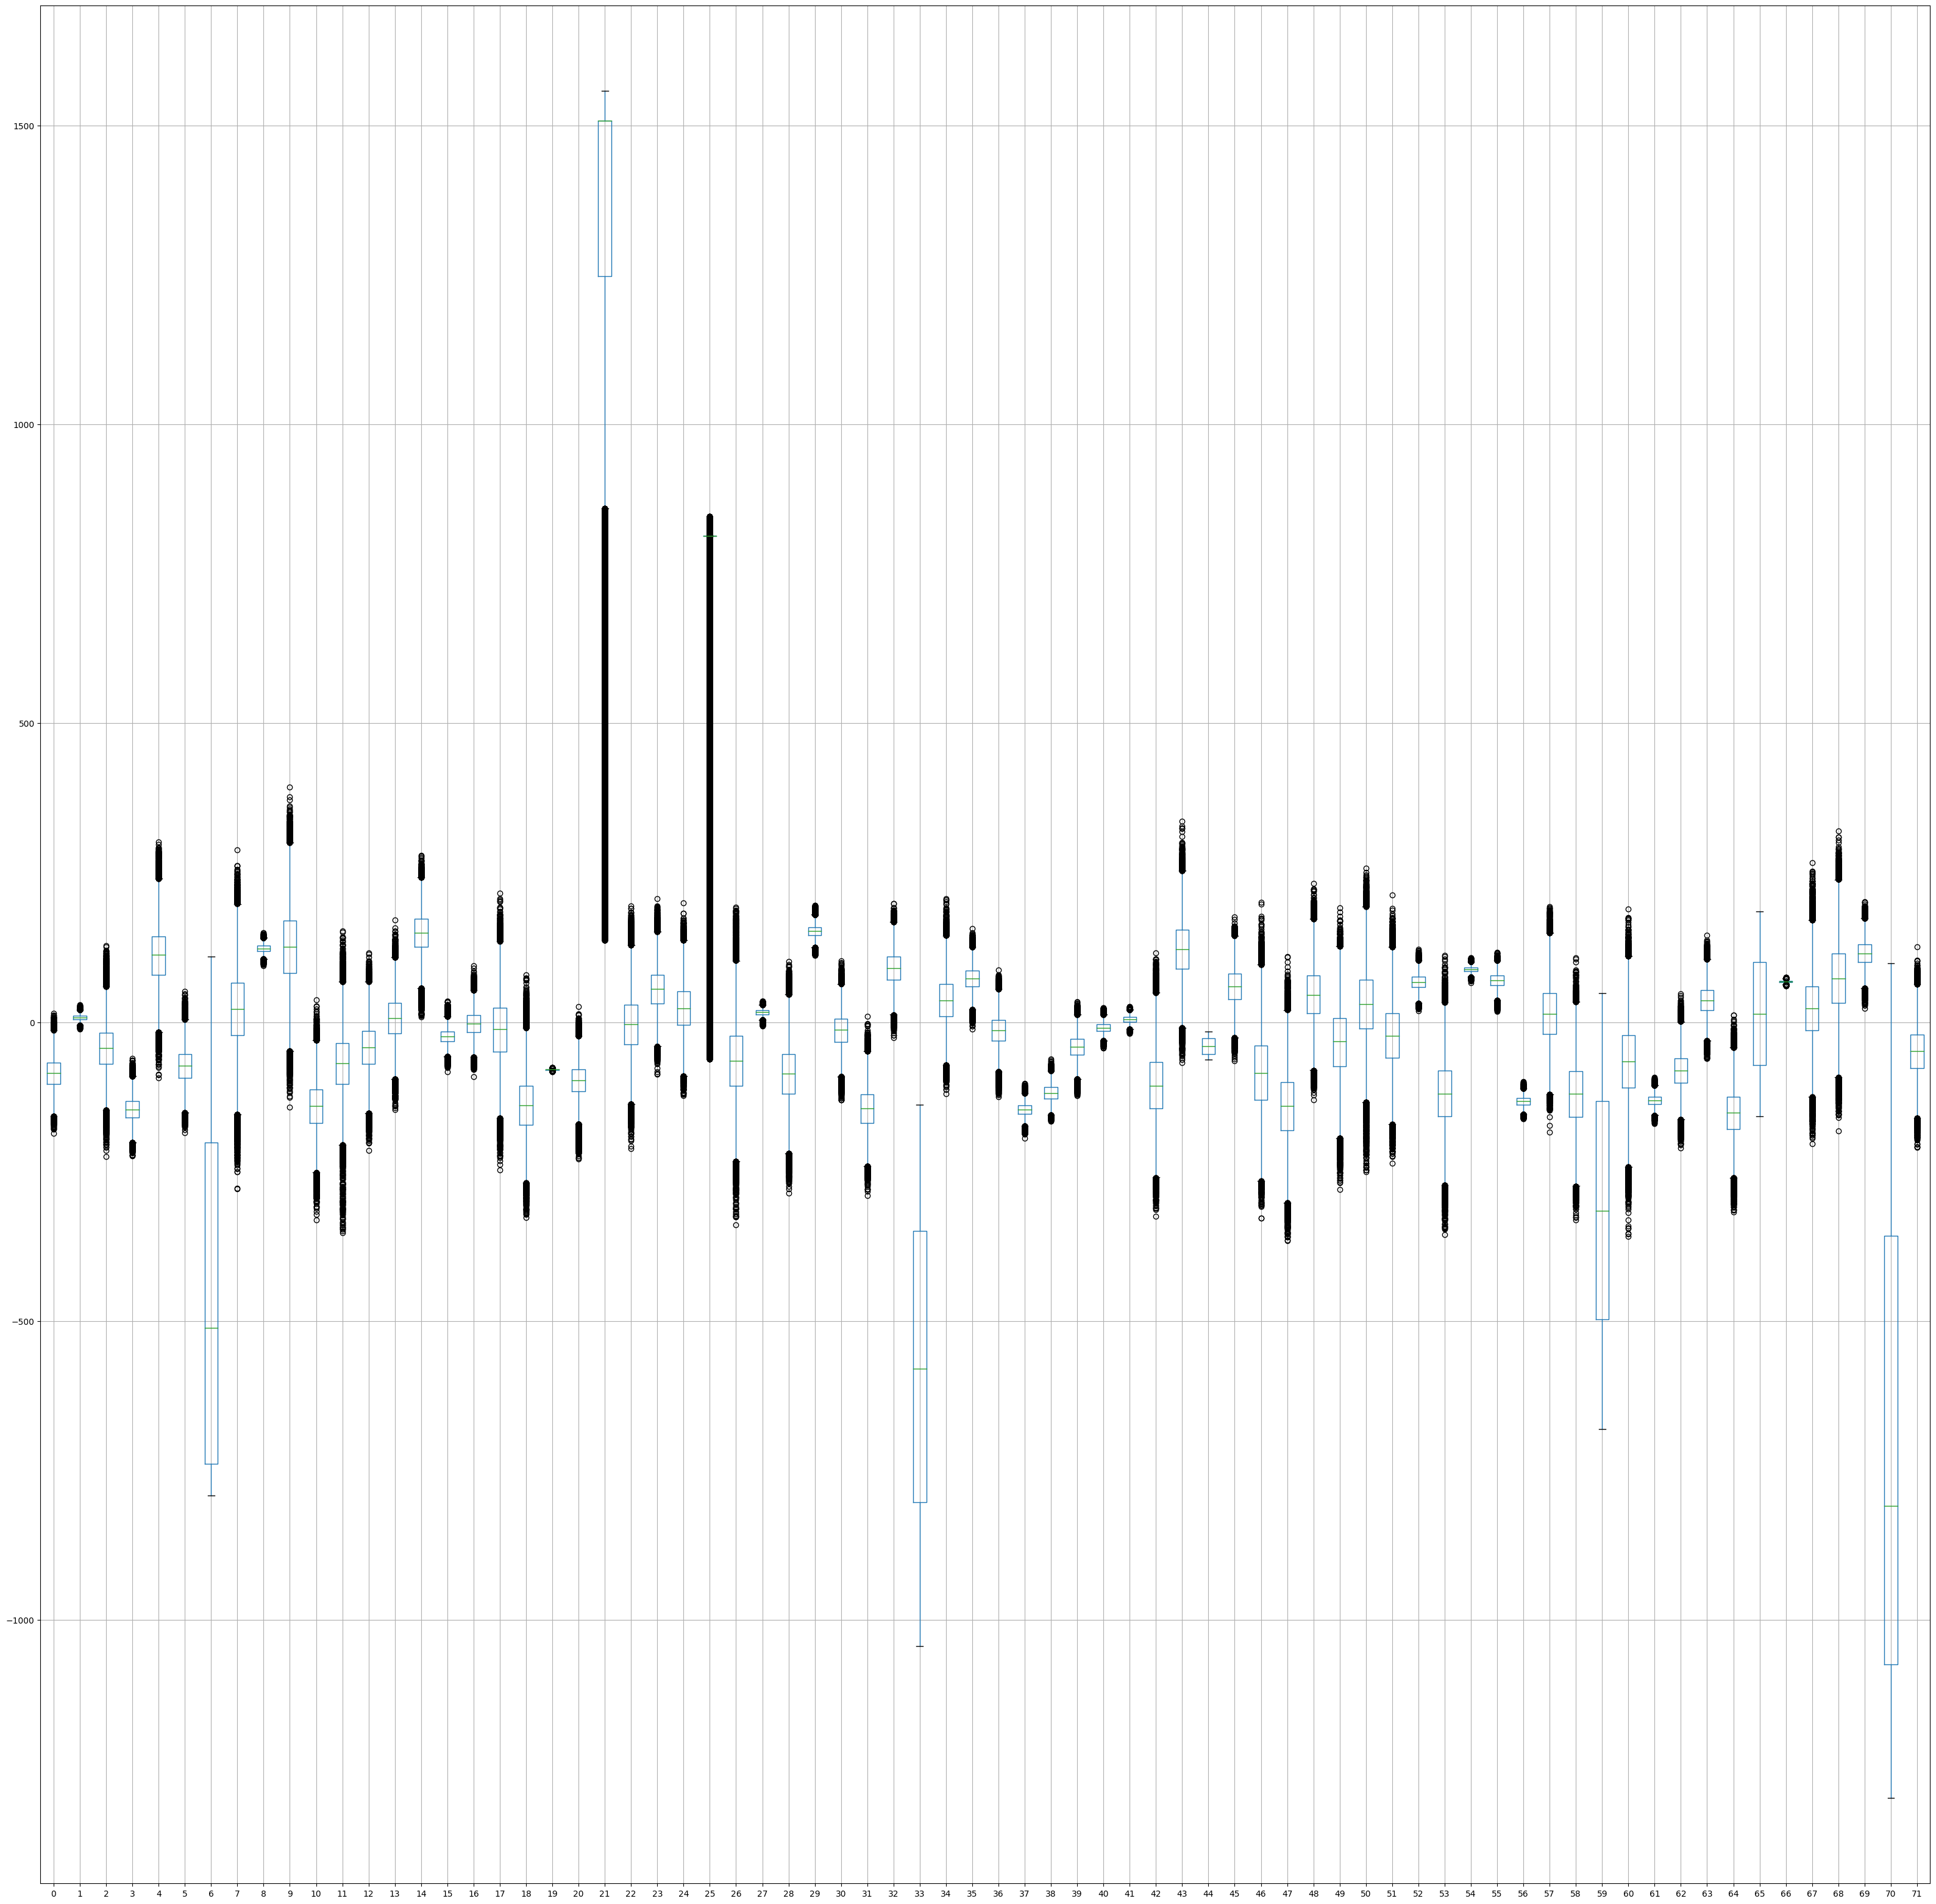

In [8]:
train.boxplot(figsize=(40,40));

Судя по графикам размаха значений, практически во всех признаках присутствуют аномалии.

In [9]:
train['7'].describe()

count    100000.000000
mean         21.231588
std          65.985214
min        -278.582820
25%         -22.131764
50%          22.278989
75%          65.899595
max         288.171840
Name: 7, dtype: float64

Хотя, из описания следует, что среднее и медианное значения не сильно разнятся. Оставим эти значения.

Теперь перейдем к признакам, распределение которых значительно отличается от нормального. (6, 21, 25, 33, 44, 59, 65, 70)

В признаке 6 значения распределены почти равномерно, но есть выбросы. Так как неизвестен смысл признаков, пока оставим как есть.

<AxesSubplot: >

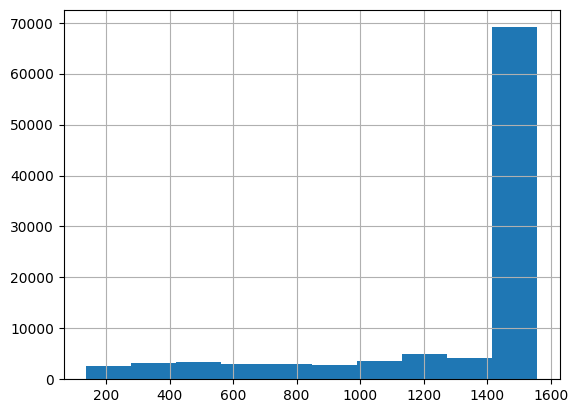

In [10]:
train['21'].hist()

Посмотрим, как в признаке распределены значения меньше 1500:

<AxesSubplot: >

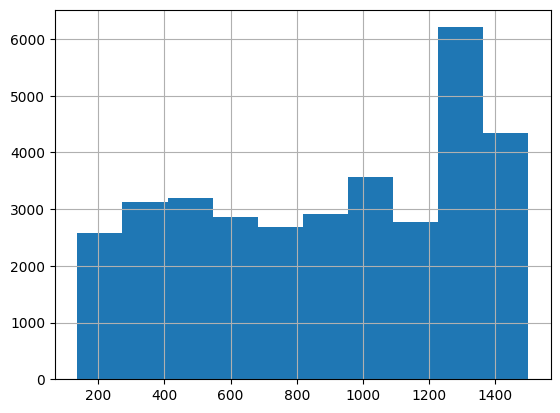

In [11]:
train[train['21']<1500]['21'].hist()

In [12]:
100 * train[train['21']<1500]['21'].count()/len(train) # сколько это процентов от всего train

34.256

Видно, что здесь распределение более равномерно, однако, все же не совсем. Оставим так

<AxesSubplot: >

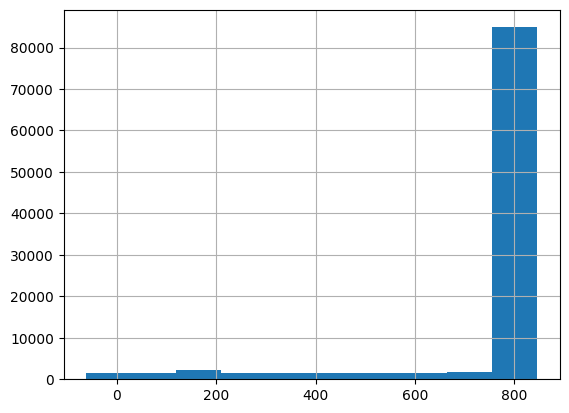

In [13]:
train['25'].hist()

Аналогично посмотрим, как в признаке распределены значения меньше 800:

<AxesSubplot: >

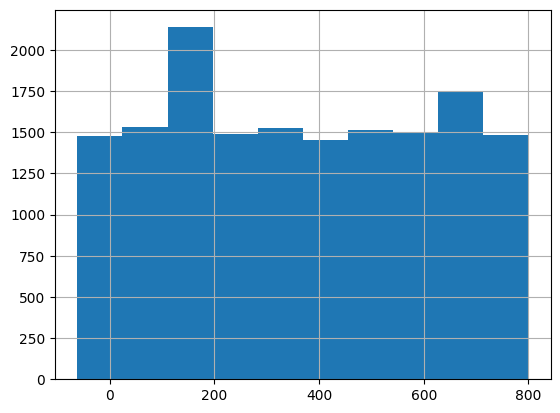

In [14]:
train[train['25']<800]['25'].hist()

In [15]:
100 * train[train['25']<800]['25'].count()/len(train) # сколько это процентов от всего train

15.855

Как и предыдущий признак, оставим без изменений.

33, 44, 59, 65, 70

<AxesSubplot: >

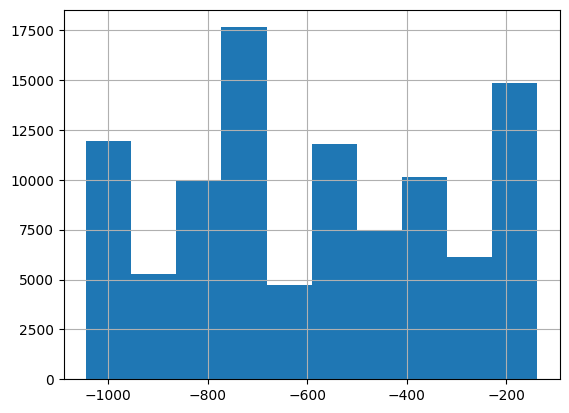

In [16]:
train['33'].hist()

Распределение неравномерно, какие-либо закономерности отстутствуют, оставим все значения.

<AxesSubplot: >

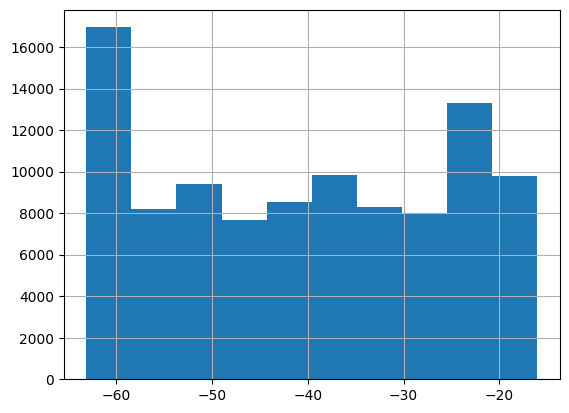

In [17]:
train['44'].hist()

<AxesSubplot: >

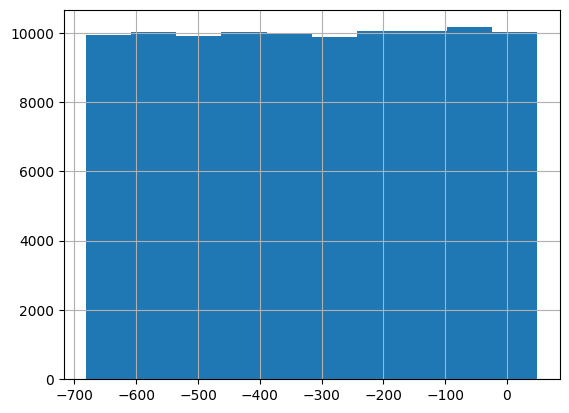

In [18]:
train['59'].hist()

Попытаемся понять, насколько значения различны.

<AxesSubplot: >

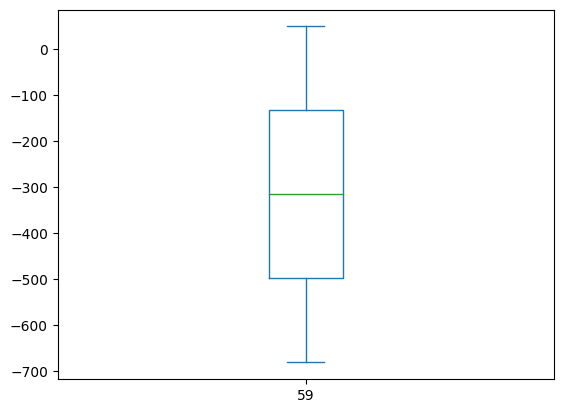

In [19]:
train['59'].plot.box()

In [20]:
len(train['59'].unique())

99999

Значения лежат в сравнительно небольшом диапазоне, однако, уникальных значений много, оставим признак.

<AxesSubplot: >

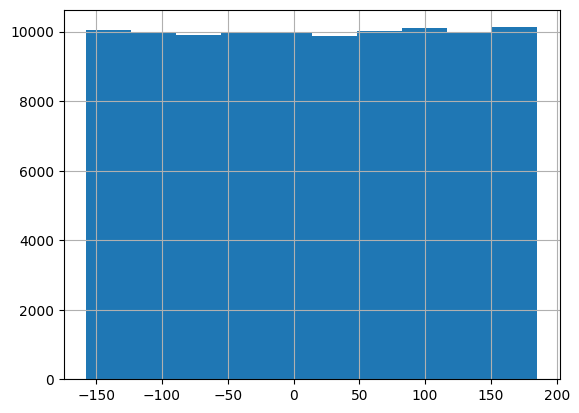

In [21]:
train['65'].hist()

In [22]:
len(train['65'].unique())

95260

Здесь похожая ситуация, тоже оставим.

<AxesSubplot: >

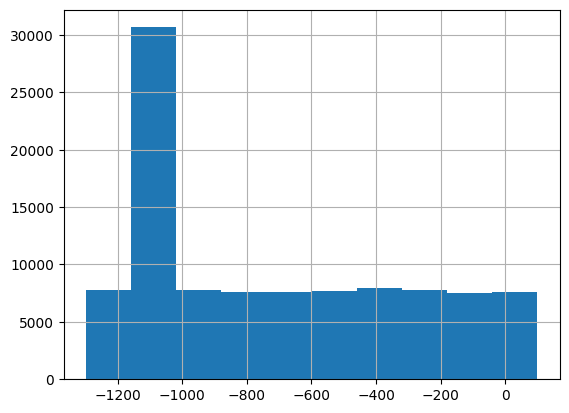

In [23]:
train['70'].hist()

Присутствует выброс, посмотрим на график размаха значений.

<AxesSubplot: >

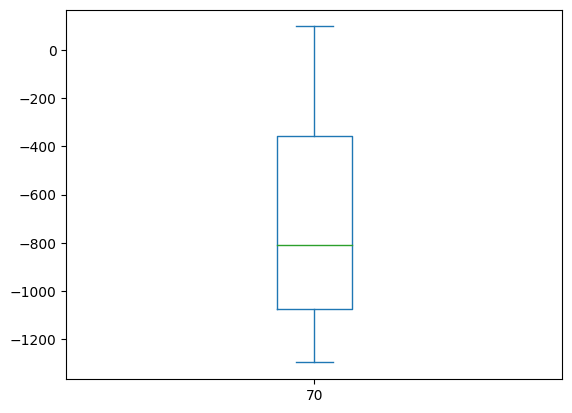

In [24]:
train['70'].plot.box()

Выброс, который виден на гистограмме, здесь не отмечен как аномалия. Оставим признак как есть

Сначала попробуем решить поставленную задачу метчинга с помощью faiss на немасштабированных данных.

Произведем кластеризацию объектов из base, зададим количество кластеров 70

In [25]:
n_clasters = 70
quantiser = faiss.IndexFlatL2(base.shape[1])
idx_l2 = faiss.IndexIVFFlat(quantiser, base.shape[1], n_clasters)

In [26]:
print(idx_l2.is_trained)

False


In [27]:
idx_l2.train(np.ascontiguousarray(base.values).astype('float32'))

In [28]:
print(idx_l2.ntotal)
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
print(idx_l2.ntotal)

0
2918139


Разделим обучающую выборку на обучающие признаки и целевой признак

In [29]:
y_train = train['Target']
x_train = train.drop('Target', axis=1)

In [30]:
r, idx = idx_l2.search(np.ascontiguousarray(x_train.values).astype('float32'), 5)

In [73]:
def acc_5(targets, indices, base_indices):
    acc = 0
    for target, e in zip(targets.values.tolist(), indices.tolist()):
        acc += int(target in [base_indices[r] for r in e])
    return 100 * acc / len(indices)

In [32]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [33]:
acc_5(y_train, idx, base_index)

8.21

### Масштабирование

Список всех признаков, кроме целевого:

In [34]:
cols = train.columns
cols = cols.drop('Target')
cols

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

Для масштабирования применим StandardScaler.

In [35]:
scaler = StandardScaler()
X_base = pd.DataFrame(scaler.fit_transform(base[cols]), index=base.index, columns=cols)

In [36]:
X_train = pd.DataFrame(scaler.transform(train[cols]), index=train.index, columns=cols)
X_test = pd.DataFrame(scaler.transform(x_test[cols]), index=x_test.index, columns=cols)

In [37]:
train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.76360,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.80333,-83.81059,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.58963,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.12843,-50.83762,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.93147,-1074.464888,-22.547178,1447819-base


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [39]:
max(train.isna().sum())

0

In [40]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


In [41]:
x_test.head(3)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604


In [42]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

In [43]:
max(x_test.isna().sum())

0

In [44]:
x_test.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,...,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,...,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,...,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,...,-101.690472,19.564135,-179.115082,-70.420034,66.546130,-13.863008,31.494840,100.538862,-1074.464888,-76.359190
50%,-85.296745,7.657888,-43.230835,-146.080365,111.959330,-73.579283,-513.922978,22.138012,123.062568,126.083595,...,-81.027250,36.414150,-151.426035,14.768218,67.800445,23.508739,72.152398,115.280990,-807.029697,-48.670001
75%,-67.422104,10.993900,-17.765821,-132.119278,143.903735,-53.861139,-202.572440,66.097697,127.538967,169.680500,...,-60.274745,53.888420,-124.400438,99.803923,69.040832,60.154775,114.317053,129.770215,-358.400478,-20.283335
max,14.427986,27.409784,134.859800,-57.381890,302.065370,50.255325,109.632035,279.468900,151.822560,392.827150,...,41.390480,141.025270,14.602035,185.094333,75.400475,251.288590,305.937530,201.599980,98.737079,111.831955


### Кластеризация и обучение

Произведем кластеризацию объектов из base, зададим количество кластеров 70

In [45]:
n_clasters = 70
quantiser = faiss.IndexFlatL2(X_base.shape[1])
idx_l2 = faiss.IndexIVFFlat(quantiser, X_base.shape[1], n_clasters)

In [46]:
print(idx_l2.is_trained)

False


In [47]:
idx_l2.train(np.ascontiguousarray(X_base.values).astype('float32'))

In [48]:
print(idx_l2.ntotal)
idx_l2.add(np.ascontiguousarray(X_base.values).astype('float32'))
print(idx_l2.ntotal)

0
2918139


Разделим обучающую выборку на обучающие признаки и целевой признак

In [49]:
y_train = train['Target']

In [50]:
r, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), 5)

In [51]:
base_index = {k: v for k, v in enumerate(X_base.index.to_list())}

In [52]:
acc_5(y_train, idx, base_index)

55.444

In [53]:
idx_l2.nprobe = 15

In [54]:
r, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), 5)

In [55]:
base_index = {k: v for k, v in enumerate(X_base.index.to_list())}

In [56]:
acc_5(y_train, idx, base_index)

65.039

In [67]:
accs = {}
for nprobe in [7, 50, 70]:
    idx_l2.nprobe = nprobe
    r, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), 5)
    base_index = {k: v for k, v in enumerate(X_base.index.to_list())}
    acc = acc_5(y_train, idx, base_index)
    accs[nprobe] = acc
print('nprobe =', max(accs, key=accs.get))
print('acc5:', max(accs))

nprobe = 70
acc5: 70


In [68]:
accs

{7: 64.434, 50: 65.832, 70: 65.838}

При дальнейшем увеличении nprobe метрика растет (до 65.832 при nprobe = 50, 65.838 при nprobe = 70), но не значительно, кроме того, растет и вычислительная сложность, поэтому остановимся на значении 15.

### Тестирование

Выполним проверку на тестовом наборе данных

In [71]:
Y_test = y_test['Expected']

In [60]:
idx_l2.nprobe = 15
r, idx = idx_l2.search(np.ascontiguousarray(X_test.values).astype('float32'), 5)
base_index = {k: v for k, v in enumerate(X_base.index.to_list())}

In [74]:
acc_5(Y_test, idx, base_index)

64.825

На тестовом наборе мы получили значение метрики чуть ниже, 64.825%.

### Вывод

Таким образом, были выполнены следующие задачи:

        - Выполнена предобработка и исследовательский анализ признаков обучающей выборки. Анализ показал, что почти все признаки имеют нормальное распределение за исключением признаков 6, 21, 25, 33, 44, 59, 65 и 70, значения которых распределены иначе. Предположительно, имело бы смысл объединить значения некоторых не нормально распределенных признаков в группы, сделав их категориальными. Но, так как мы не располагаем информацией о сути этих данных, можем потерять важные значения, если будем производить подобные манипуляции.
        - Выполнено также масштабирование численных признаков (все признаки, кроме целевого) с помощью StandardScaler;

        - Оценено качество решения задачи поиска похожих товаров на немасштабированных, а затем - на масштабированных данных. Масштабирование позволяет повысить качество решения задачи мэтчинга с 8.21 % до 55.444 %.
        - Установление значения nprobe - числа близжайших кластеров, из которых выбирать наиболее похожие элементы, позволяет улучшить метрику до 65.039% со значением nprobe = 15,
        - Качество обученного алгоритма оценено на тестовом наборе данных. Полученное значение метрики составляет 64.825%.